In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
#!pip install Equation
from Equation import Expression

In [2]:
from scipy.stats import norm

In [3]:
from itertools import chain, combinations
import itertools

In [4]:
from unittest.mock import patch
import unittest

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import collections
from copy import deepcopy
from scipy.stats import norm

In [42]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.utils.data import Dataset, DataLoader

In [7]:
# Helper Functions
def powerset(iterable):
    "Function: powerset([1,2,3]) --> [() (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)]"
    "Input: List"
    "Output: List of Tuples which are Elements of the Power Set"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]

In [19]:
powerset([1,2,3])

[(1,), (2,), (3,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]

In [20]:
class RCA_Network:
    def __init__(self):
        self.G = nx.DiGraph()
        self.fm_size = int(input("Enter Number of Failure Modes"))
        self.st_size = int(input("Enter Number of Sensors"))
        self.failure_modes = []
        self.sensors = []
        
        while(len(self.failure_modes) != self.fm_size):
            inp_fm = input(f"Enter failure mode name (String) {len(self.failure_modes)+1}: ")
            inp_save = input(f"Save {inp_fm} ? (y/n): ")
            if inp_save == 'y':
                self.failure_modes.append(inp_fm)
        
        for i in range(self.fm_size):
            self.G.add_node(self.failure_modes[i])
        
        while(len(self.sensors) != self.st_size):
            inp_st = input(f"Enter sensor type name (String) {len(self.sensors)+1}: ")
            inp_save = input(f"Save {inp_st} ? (y/n): ")
            if inp_save == 'y':
                self.sensors.append(inp_st)
                
        for i in range(self.st_size):
            self.G.add_node(self.sensors[i])
        
        
        self.adj_mat = nx.to_numpy_array(self.G)
        self.ftos_mat = np.max(self.adj_mat, axis = 0)[self.fm_size:]
        self.all_sensor_good = np.min(self.ftos_mat)
        self.bad_sensor = -1
        if(self.all_sensor_good == 0):
            self.bad_sensor = np.argmin(self.ftos_mat)
            
        while(self.all_sensor_good == 0):
            print(f"Enter failure modes detected by sensor {self.sensors[self.bad_sensor]}")
            for j in range(self.fm_size):
                inp_fmv = input(f"Is failure mode {self.failure_modes[j]} detected by this sensor ? (y/n): ")
                if inp_fmv == 'y':
                    self.G.add_edge(self.failure_modes[j], self.sensors[self.bad_sensor])
            self.adj_mat = nx.to_numpy_array(self.G)
            self.ftos_mat = np.max(self.adj_mat, axis = 0)[self.fm_size:]
            self.all_sensor_good = np.min(self.ftos_mat)
            if(self.all_sensor_good == 0):
                self.bad_sensor = np.argmin(self.ftos_mat)
            #print(self.all_sensor_good)
            #print(self.ftos_mat)
            #print(self.adj_mat)
            #print(self.bad_sensor, np.argmin(self.ftos_mat), self.fm_size)
        
        print('Bayesian Network Complete')
        return None
        
    def get_graph(self):
        return self.G
    
    def get_adj_matrix(self):
        return nx.to_numpy_array(self.G)
    
    def plot_graph(self):
        colour_map = ['blue' for f in self.failure_modes] + ['yellow' for s in self.sensors]
        size_map = [2000 for f in self.failure_modes] + [1000 for s in self.sensors]
        plt.figure(figsize=(10,10))
        pos = nx.bipartite_layout(self.G, self.failure_modes, align='horizontal')
        nx.draw_networkx_nodes(self.G, pos, node_color = colour_map, node_size = size_map, alpha=0.4, edgecolors='black', linewidths=2)
        nx.draw_networkx_labels(self.G, pos, font_weight='bold')
        nx.draw_networkx_edges(self.G, pos, arrowsize=25, connectionstyle="arc3,rad=-0.1", min_source_margin=22, min_target_margin=16)
    
    def get_detected_dict(self):
        RCAG = self.G
        detected_dic = {}
        for nd in list(RCAG.nodes())[fs:]:
            detected_dic.update({nd:[x[0] for x in RCAG.in_edges(nd)]})
        return detected_dic

In [21]:
def test_rca_network(fs, ss, cs):
    
    inputs = []
    finputs = []
    sinputs = []
    inputs.append(str(fs))
    inputs.append(str(ss))
    for i in range(fs):
        inputs.append('F' + str(i+1))
        finputs.append('F' + str(i+1))
        inputs.append('y')
    
    for i in range(ss):
        inputs.append('S' + str(i+1))
        sinputs.append('S' + str(i+1))
        inputs.append('y')
        
    all_edges = list(itertools.product(sinputs, finputs))
    B = nx.algorithms.bipartite.generators.gnmk_random_graph(ss, fs, cs, directed=True)
    relabel_dict = {k:v for k,v in enumerate(sinputs + finputs)}
    B = nx.relabel_nodes(B, relabel_dict)
    cur_edges = list(B.edges)
    
    print(all_edges, cur_edges)

    for ed in all_edges:
        if ed in cur_edges:
            inputs.append('y')
        else:
            inputs.append('n')
    
    #inputs = ['3', '2', 'F1', 'y', 'F2', 'y', 'F3', 'y', 'S1', 'y', 'S2', 'y', 'y', 'y', 'n', 'n', 'y', 'y']
    #print(inputs)
    with patch('builtins.input', side_effect=inputs):
        network = RCA_Network()
    return network

In [22]:
fsnames = ['F1', 'F2', 'F3']
ssnames = ['S1', 'S2']
fnames = fsnames
snames = ssnames
fs = 3
ss = 2
cs = 5
network = test_rca_network(fs, ss, cs)

[('S1', 'F1'), ('S1', 'F2'), ('S1', 'F3'), ('S2', 'F1'), ('S2', 'F2'), ('S2', 'F3')] [('S1', 'F2'), ('S1', 'F3'), ('S2', 'F2'), ('S2', 'F1'), ('S2', 'F3')]
Enter failure modes detected by sensor S1
Enter failure modes detected by sensor S2
Bayesian Network Complete


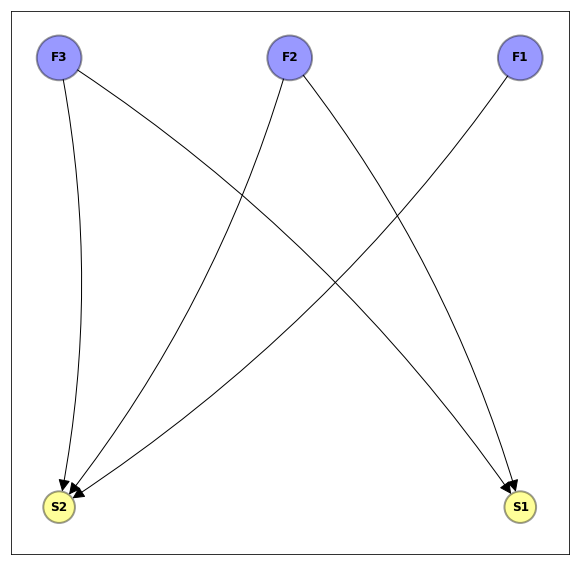

In [23]:
network.plot_graph()

In [24]:
det_dic = network.get_detected_dict()
[x for x in det_dic.values()]

[['F2', 'F3'], ['F1', 'F2', 'F3']]

In [25]:
noise_level = 0.1
failure_probs = np.random.uniform(0, 1, fs)
signal_combinations = [list(x) for y in [powerset(x) for x in det_dic.values()] for x in y]
total_signal_combinations = len(signal_combinations)

onehot_signal_combinations = []
for sig in signal_combinations:
    base_sig = np.zeros(fs)
    for f in sig:
        base_sig[int(f.replace('F',''))-1] = 1
    onehot_signal_combinations.append(base_sig)
onehot_signal_combinations = np.array(onehot_signal_combinations)

# Cross Correlate the Signals

param_size = np.sum([len(x) for x in det_dic.values()]) + ss
signal_noise = noise_level*np.random.randn(param_size)
base_params = np.random.uniform(-3, 3, param_size)
default_params = 10**(base_params)
expert_params = 10**(base_params + signal_noise)
failure_probs, len(default_params), len(expert_params), default_params, expert_params, onehot_signal_combinations

(array([0.84721282, 0.52664105, 0.42794242]),
 7,
 7,
 array([1.38457405e-02, 2.11479820e+00, 1.57962960e+00, 2.35045263e+02,
        2.10386726e-03, 4.92715777e+00, 2.14033394e-03]),
 array([1.85738758e-02, 1.63402305e+00, 1.31280317e+00, 1.95327920e+02,
        1.53812664e-03, 5.20152274e+00, 2.76833601e-03]),
 array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.]]))

In [26]:
class Signal_Data_Generator():
    
    def __init__(self, fs, ss, failure_probs, default_params, total_signal_combinations, onehot_signal_combinations, det_dic, signal_noise=1):
        
        self.fs = fs
        self.ss = ss
        self.failure_probs = failure_probs
        self.tsc = total_signal_combinations
        self.default_params = default_params
        self.ohsc = onehot_signal_combinations
        self.det_dic = det_dic
        self.signal_noise = signal_noise
        
    def sample(self, t1=0, t2=1, sf=1000):
        t = np.linspace(t1, t2, sf)
        mode = np.zeros(len(self.failure_probs))
        for i, fp in enumerate(self.failure_probs):
            mode[i] = np.random.choice([1,0], 1, p=[fp, 1-fp])[0]
            
        out_sig = [np.sin(default_params[len(default_params) - self.ss + x]*t) for x in range(self.ss)]
        #return out_sig, mode
        print(mode)
        pos = 0
        for i in range(ss):
            print(i)
            for fm in list(self.det_dic.values())[i]:
                print(fm)
                fmind = int(fm.replace('F', '')) - 1
                if(mode[fmind] == 1):
                    print(pos)
                    out_sig[i] += np.sin(self.default_params[pos]*t)
                pos += 1
        
        start = t1
        end =t2
        sampling = sf
        window_size = 100
        signal = np.array(out_sig)
        timeline = np.array(t)
        
        partitions = np.int(sampling/window_size)
        
        print(partitions)
        
        signal = np.array(np.split(signal, partitions, axis=1)).reshape(partitions, window_size, self.ss)
        timeline = np.array(np.split(timeline.reshape(1,-1), partitions, axis=1)).reshape(partitions, window_size, 1)
        #derivative = np.array(np.split(derivative, np.int((end - start)*sampling/window_size)))

        print(signal.shape, timeline.shape) 
        #print(derivative.shape)

        signal = torch.from_numpy(signal)
        timeline = torch.from_numpy(timeline)
        #derivative = torch.from_numpy(derivative)

        signal = torch.tensor(signal, requires_grad=True)
        timeline = torch.tensor(timeline, requires_grad=True)
        #derivative = torch.tensor(derivative, requires_grad=True)
        
        return signal, timeline, out_sig, mode

In [27]:
data = Signal_Data_Generator(fs, ss, failure_probs, default_params, total_signal_combinations, onehot_signal_combinations, det_dic, signal_noise=1)

[0. 1. 1.]
0
F2
0
F3
1
1
F1
F2
3
F3
4
20
(20, 100, 2) (20, 100, 1)


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


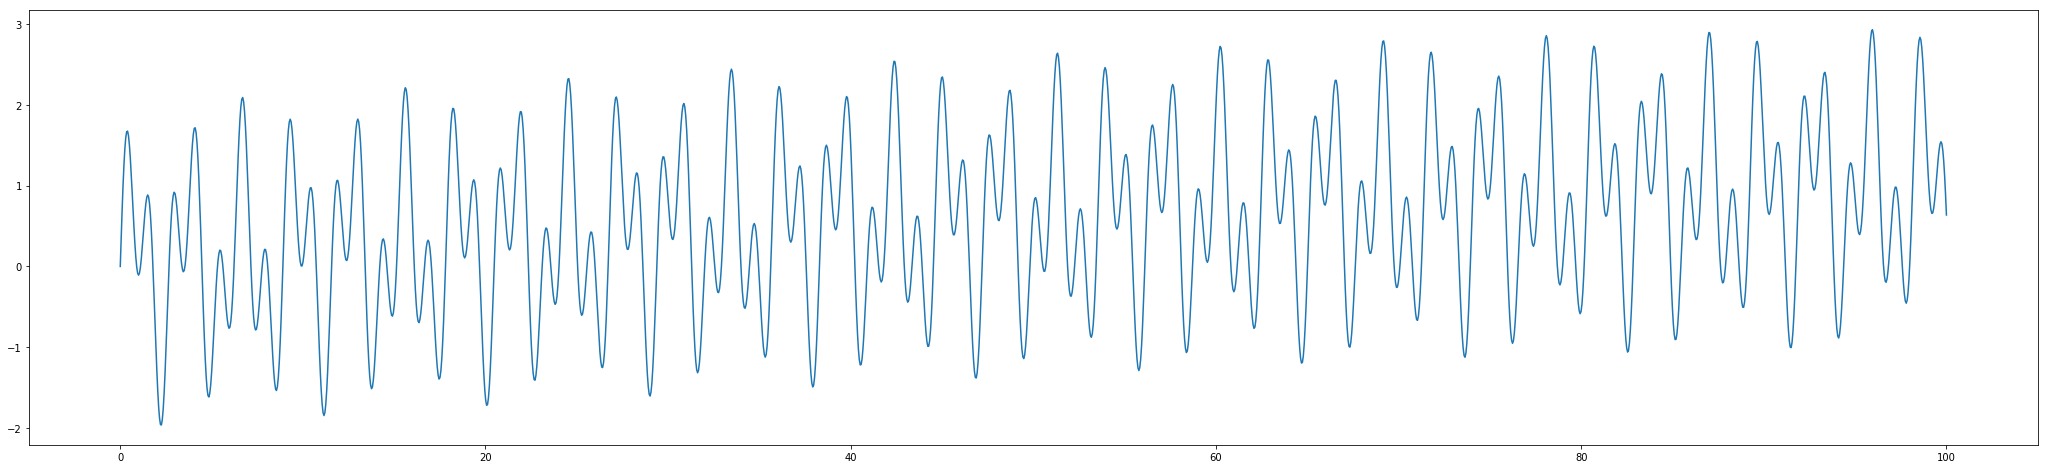

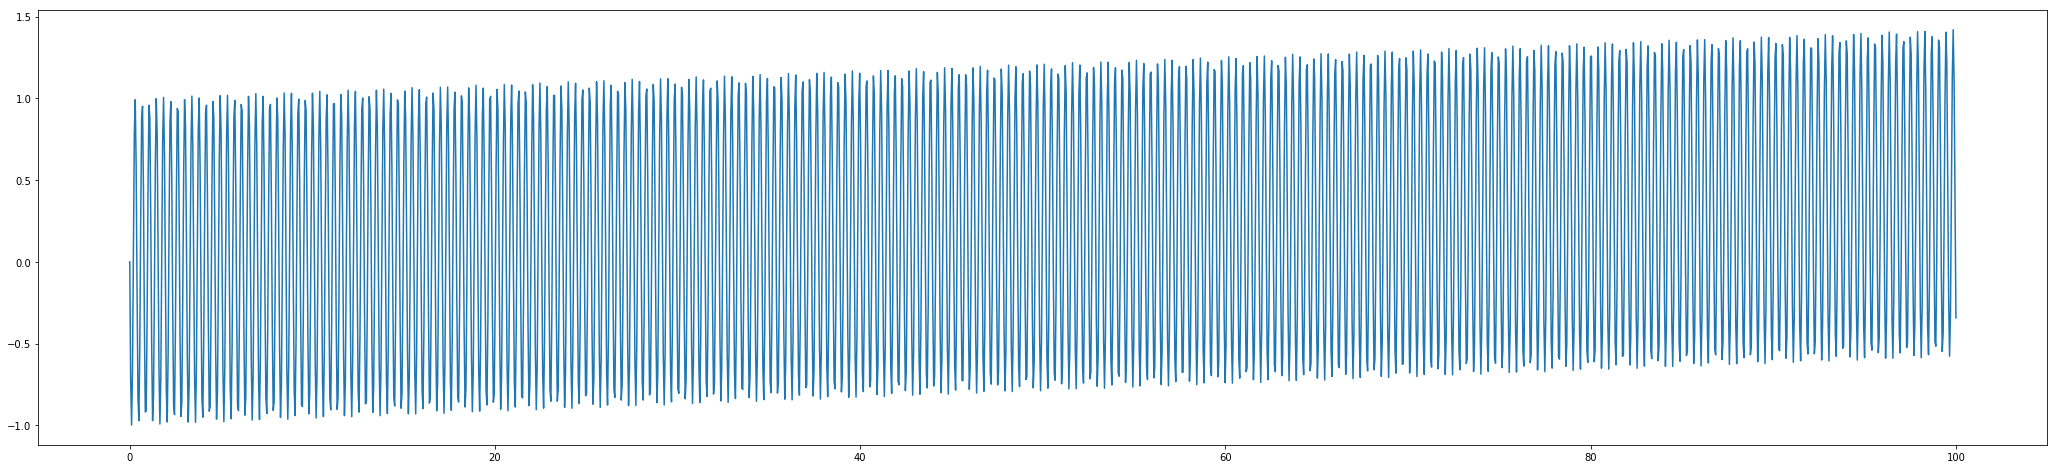

array([0., 1., 1.])

In [28]:
#np.random.seed(10)
start = 0
stop = 100
samples = 2000

samp_res = data.sample(start, stop, samples)
for i in range(ss):
    plt.figure(figsize=(36, 8))
    plt.plot(np.linspace(start, stop, samples), samp_res[2][i])
    plt.show()
samp_res[-1]

In [29]:
class Expert_Guidance:
    
    def __init__(self, fs, fnames, ss, snames, onehot_signal_combinations):
        self.fnames = fnames
        self.fm_size = fs
        
        self.snames = snames
        self.ss_size = ss
        
        self.ohc = onehot_signal_combinations
        self.mode_eqns = {}
        for sn in self.snames:
            self.mode_eqns.update({sn : []})
        
        print('Stable Mode Equations')
        for i, sn in enumerate(self.snames):
            while(np.sum([len(x) for x in self.mode_eqns.values()]) != self.ss_size):
                inp_eqn = input(f"Enter variables followed by equation - 'x, sin(x)' for Sensor {sn} Stable Mode: ")
                inp_save = input(f"Save {inp_eqn} ? (y/n): ")
                print(inp_eqn.split(', '))
                if inp_save == 'y':
                    self.mode_eqns[sn].append(Expression(inp_eqn.split(', ')[1], [inp_eqn.split(', ')[0]]))
            
        print('Failure Mode Equations')
        print(f"Current Failure Modes are {' '.join(fnames)}")
        print('1 indicates Failure Mode is Active and 0 indicates Failure Mode is off')
        print('Modes are One Hot Encoded, example: [1,0,0] indicates F1 is on, others are off for three failure modes')
              
        count = 1
        for mode in self.ohc:
            count += 1
            for i, sn in enumerate(self.snames):
                while(len(self.mode_eqns[sn]) != count):
                    inp_eqn = input(f"Enter variables followed by equation - 'x, sin(x)' for Sensor {sn} for Mode {mode}: ")
                    inp_save = input(f"Save {inp_eqn} ? (y/n): ")
                    if inp_save == 'y':
                        self.mode_eqns[sn].append(Expression(inp_eqn.split(', ')[1], [inp_eqn.split(', ')[0]]))
        
    def get_stable_modes(self):
        stable_eqns = [x[0] for x in self.mode_eqns.values()]    
        return stable_eqns

    def get_failure_modes(self):
        failure_eqns = [x[1:] for x in self.mode_eqns.values()]
        return failure_eqns

    def get_equations(self):
        return self.mode_eqns
              
    def show_equations(self):
        for k, v in self.mode_eqns.items():
            print(k,v)
        
    def test_equations(self, test_nums):
        
        for i in range(len(self.ohc) + 1):
            plt.figure(figsize=(10, 6))  
            for sen in self.mode_eqns.keys():
                print(self.mode_eqns[sen][i])
                plt.plot(test_nums, self.mode_eqns[sen][i](test_nums))
            plt.show()

In [33]:
expert_signals = {}
expert_signals.update({"S1": [f"sin({expert_params[-2]}*t)"]})
expert_signals.update({"S2": [f"sin({expert_params[-1]}*t)"]})
fsnames = ['F1', 'F2', 'F3']
ssnames = ['S1', 'S2']
for comb in onehot_signal_combinations:
    print(comb)
    for j, sn in enumerate(ssnames):
        temp_sig = expert_signals[sn][0]
        for i, fn in enumerate(fsnames):
            if((comb[i] == 1) and (fn in list(det_dic.values())[j])):
                temp_sig = temp_sig + " + " + f"sin({expert_params[j*len(list(det_dic.values())[j]) + i]}*t)"        
        expert_signals[sn].append(temp_sig)
expert_signals

[0. 1. 0.]
[0. 0. 1.]
[0. 1. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 1. 0.]
[1. 0. 1.]
[0. 1. 1.]
[1. 1. 1.]


{'S1': ['sin(5.201522737168661*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t)',
  'sin(5.201522737168661*t) + sin(1.3128031709487116*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t) + sin(1.3128031709487116*t)',
  'sin(5.201522737168661*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t)',
  'sin(5.201522737168661*t) + sin(1.3128031709487116*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t)',
  'sin(5.201522737168661*t) + sin(1.3128031709487116*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t) + sin(1.3128031709487116*t)',
  'sin(5.201522737168661*t) + sin(1.6340230516455345*t) + sin(1.3128031709487116*t)'],
 'S2': ['sin(0.0027683360100351864*t)',
  'sin(0.0027683360100351864*t) + sin(0.001538126642950696*t)',
  'sin(0.0027683360100351864*t) + sin(5.201522737168661*t)',
  'sin(0.0027683360100351864*t) + sin(0.001538126642950696*t) + sin(5.201522737168661*t)',
  'sin(0.0027683360100351864*t) + sin(195.32792012817902*t)',
  'sin(0.

In [34]:
def test_expert_guidance(fs, fnames, ss, snames, onehot_signal_combinations, expert_signals):
    inputs = []
    
    for i, sn in enumerate(snames):
        inputs.append(f't, {expert_signals[sn][0]}')
        inputs.append('y')
    
    for cm, comb in enumerate(onehot_signal_combinations):
        for i, sn in enumerate(snames):
            inputs.append(f't, {expert_signals[sn][1+cm]}')
            inputs.append('y')
    
    print(inputs)
    
    with patch('builtins.input', side_effect=inputs):
        expert = Expert_Guidance(fs, fnames, ss, snames, onehot_signal_combinations)
    return expert

In [35]:
G = network.get_graph()
fnames = list(G.nodes)[:fs]
snames = list(G.nodes)[fs:]
expert = test_expert_guidance(fs, fnames, ss, snames, onehot_signal_combinations, expert_signals)
expert.show_equations()

['t, sin(5.201522737168661*t)', 'y', 't, sin(0.0027683360100351864*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.6340230516455345*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(0.001538126642950696*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.3128031709487116*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(5.201522737168661*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.6340230516455345*t) + sin(1.3128031709487116*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(0.001538126642950696*t) + sin(5.201522737168661*t)', 'y', 't, sin(5.201522737168661*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(195.32792012817902*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.6340230516455345*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(0.001538126642950696*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.3128031709487116*t)', 'y', 't, sin(0.0027683360100351864*t) + sin(5.201522737168661*t)', 'y', 't, sin(5.201522737168661*t) + sin(1.6340230516455345*t)', 'y', 't, sin(0.0027683360100351864*t) + s

\sin\left(\left(5.20152 \times t\right)\right)
\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right)


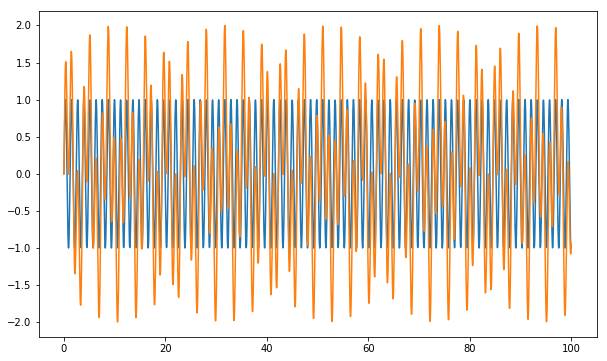

\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right)
\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right)


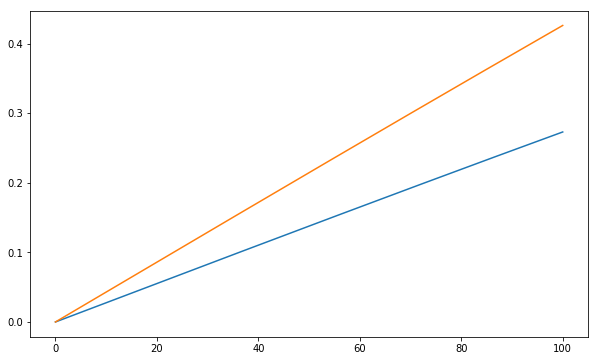

\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


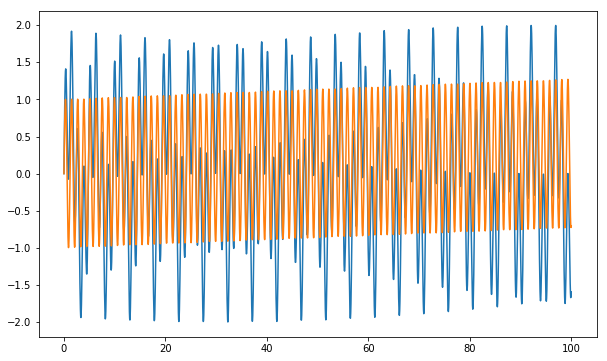

\left(\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


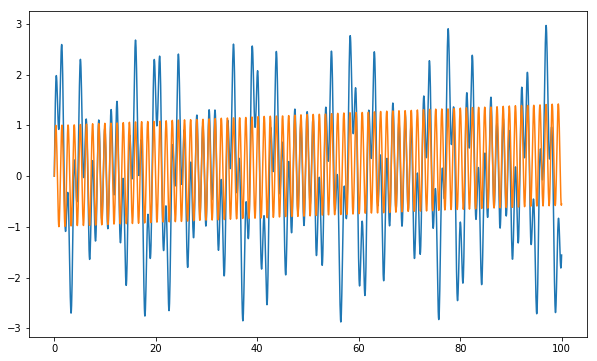

\sin\left(\left(5.20152 \times t\right)\right)
\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.95328\times10^{2}\right) \times t\right)\right)\right)


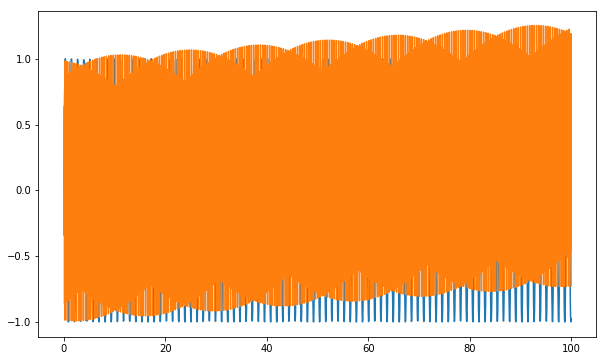

\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right)
\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right)


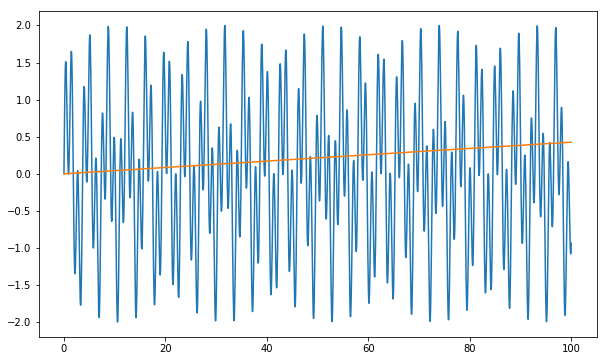

\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


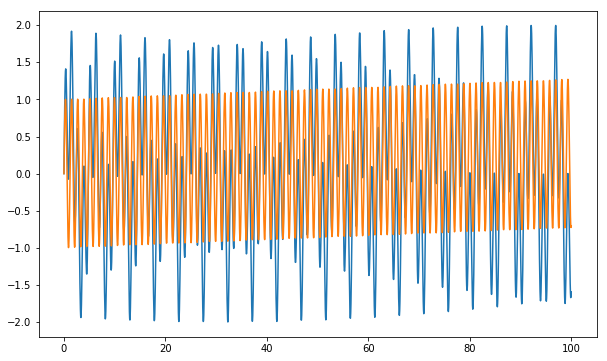

\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.95328\times10^{2}\right) \times t\right)\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right)


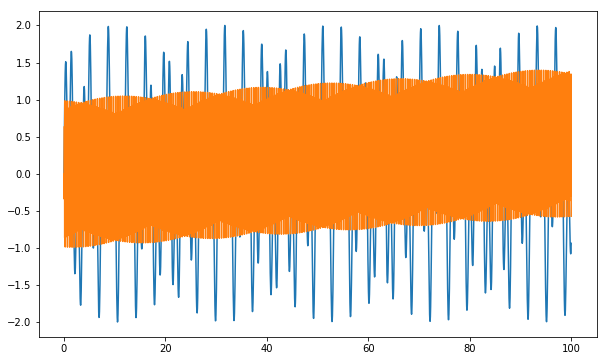

\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.95328\times10^{2}\right) \times t\right)\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


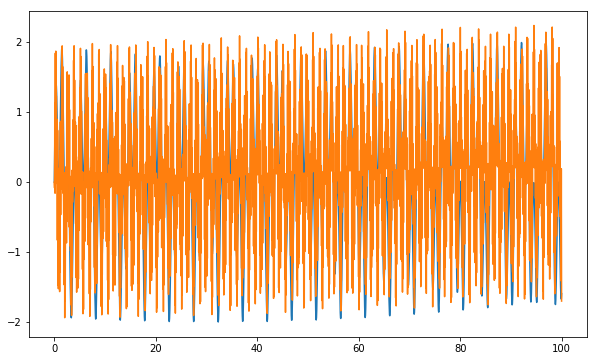

\left(\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


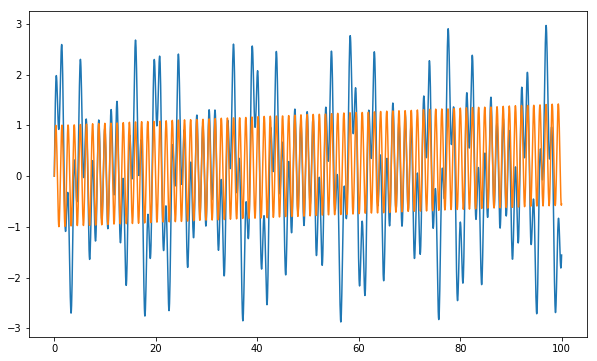

\left(\left(\sin\left(\left(5.20152 \times t\right)\right) + \sin\left(\left(1.63402 \times t\right)\right)\right) + \sin\left(\left(1.3128 \times t\right)\right)\right)
\left(\left(\left(\sin\left(\left(\left(2.76834\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.95328\times10^{2}\right) \times t\right)\right)\right) + \sin\left(\left(\left(1.53813\times10^{-3}\right) \times t\right)\right)\right) + \sin\left(\left(5.20152 \times t\right)\right)\right)


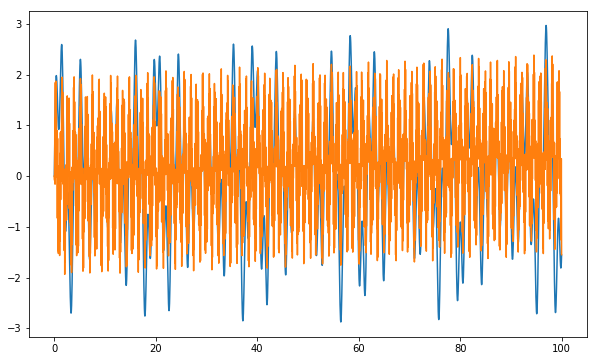

([sin((5.201522737168661 * t)),
  (sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t)))],
 [[sin((0.0027683360100351864 * t)),
   (sin((5.201522737168661 * t)) + sin((1.3128031709487116 * t))),
   ((sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t))) + sin((1.3128031709487116 * t))),
   sin((5.201522737168661 * t)),
   (sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t))),
   (sin((5.201522737168661 * t)) + sin((1.3128031709487116 * t))),
   (sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t))),
   (sin((5.201522737168661 * t)) + sin((1.3128031709487116 * t))),
   ((sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t))) + sin((1.3128031709487116 * t))),
   ((sin((5.201522737168661 * t)) + sin((1.6340230516455345 * t))) + sin((1.3128031709487116 * t)))],
  [(sin((0.0027683360100351864 * t)) + sin((0.001538126642950696 * t))),
   (sin((0.0027683360100351864 * t)) + sin((5.201522737168661 * t))),
   ((sin((0.0027683360100351864 * t)) + sin((0.00

In [40]:
expert.get_stable_modes(), expert.get_failure_modes(), expert.get_equations(), expert.test_equations(np.linspace(0, 100, 2000))

In [45]:
class Convert_Signal_Data(torch.utils.data.Dataset):
    def __init__(self, signal, timeline):
        self.signal = signal
        self.timeline = timeline

    def __len__(self):
        return len(self.signal)-1

    def __getitem__(self, idx):
        
        outix = self.signal[idx]
        outit = self.timeline[idx]
        
        outox = self.signal[idx + 1]
        outot = self.timeline[idx + 1]
        
        return outix, outit, outox, outot

In [47]:
cur_signal, cur_timeline, orig_sig, cur_mode = data.sample(start, stop, samples)
cur_loader = Convert_Signal_Data(cur_signal[:-9], cur_timeline[:-9])

[1. 1. 0.]
0
F2
0
F3
1
F1
2
F2
3
F3
20
(20, 100, 2) (20, 100, 1)


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [49]:
cur_loader, cur_signal.shape

(<__main__.Convert_Signal_Data at 0x1f9cb9c19e8>, torch.Size([20, 100, 2]))

In [171]:
lstm_input_dim = cur_signal.shape[-1] + 1
lstm_hidden_dim = cur_signal.shape[-2]*lstm_input_dim*2
lstm_batch_size = 10
lstm_output_dim = (cur_signal.shape[-1] + 1)*cur_signal.shape[-2]
lstm_num_layers = 3
lstm_num_epochs = 20

In [172]:
# Here we define our model as a class
class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers=3, num_epochs=5):
        
        self.input_size = input_dim
        self.hidden_size = hidden_dim
        self.layers_size = num_layers
        self.output_size = output_dim
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        super(LSTM, self).__init__()
        # Define the LSTM layer
        self.lstm = self.model = nn.LSTM(self.input_size, self.hidden_size, self.layers_size, batch_first=True)
        # Define the output layer
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.layers_size, self.batch_size, self.hidden_size),
                torch.zeros(self.layers_size, self.batch_size, self.hidden_size))
 
    def forward(self, inputs, current_batch):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(inputs.view(current_batch, inputs.shape[1], inputs.shape[2]))
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out)
        return y_pred
    
    def loss_fn(self, output, target):
        loss = torch.mean((output.double() - target.double())**2)
        return loss

In [173]:
class Model_Trainer:
    
    def __init__(self, model, epochs):
        self.model = model
        self.num_epochs = epochs
        self.learning_rate = 0.001
        self.loss_history = np.zeros(self.num_epochs)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def update_model(self, train_loader):
        for ep in range(self.num_epochs):
            for in_sigseq, in_timseq, out_sigseq, out_timseq in train_loader:
                self.model.zero_grad()
                self.model.hidden = self.model.init_hidden()
                current_batch = in_sigseq.shape[0]
                
                input_signal = torch.tensor(in_sigseq, requires_grad=True)
                input_timeline = torch.tensor(in_timseq, requires_grad=True)
                #print(input_signal.shape, input_timeline.shape)
                inputs = torch.cat((input_signal, input_timeline), dim=2, out=None)
                inputs = inputs.view(current_batch, inputs.shape[1], inputs.shape[2]).float()

                y_pred = self.model.forward(inputs, current_batch)
                #print(inseq.shape, y_pred.shape, y_pred[:,-1,:].shape)
                y_pred = y_pred[:,-1,:].view(current_batch, in_sigseq.shape[1], in_sigseq.shape[-1]+1)

                y_act = torch.cat((out_sigseq, out_timseq), dim=2, out=None)
                y_act = y_act.view(current_batch, out_sigseq.shape[1], out_sigseq.shape[-1]+1)

                loss = self.model.loss_fn(y_pred, y_act)

                # Zero out gradient, else they will accumulate between epochs
                self.optimizer.zero_grad()

                # Backward pass
                loss.backward()
                # Update parameters
                self.optimizer.step()
            
            plt.figure(figsize=(10,6))
            plt.plot(y_pred.detach().numpy()[0,:,0], label='pred')
            plt.plot(y_act.detach().numpy()[0,:,0], label='act')
            plt.legend()
            plt.show()
            print("Epoch ", ep+1, "MSE: ", loss.item())
            self.loss_history[ep] = loss.item()
        print("Training Completed")
    
    def predict(self, test_loader):
        for in_sigseq, in_timseq, out_sigseq, out_timseq in test_loader:
            current_batch = in_sigseq.shape[0]
            input_signal = torch.tensor(in_sigseq, requires_grad=True)
            input_timeline = torch.tensor(in_timseq, requires_grad=True)
            inputs = torch.stack((input_signal, input_timeline), dim=3, out=None)
            inputs = inputs.view(current_batch, inputs.shape[1], inputs.shape[2]).float()

            predseq = lstm(inputs, current_batch)
            predseq = predseq[:,-1,:].view(current_batch, in_sigseq.shape[1], input_size)

            inseq = inputs

            outseq = torch.stack((out_sigseq, out_timseq), dim=2, out=None)
            outseq = outseq.view(current_batch, out_sigseq.shape[1], input_size)

            grad_seq = y_pred - inputs

In [174]:
m1 = LSTM(lstm_input_dim, lstm_hidden_dim, lstm_batch_size, lstm_output_dim, lstm_num_layers, lstm_num_epochs)

In [175]:
m1t = Model_Trainer(m1, lstm_num_epochs)

C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


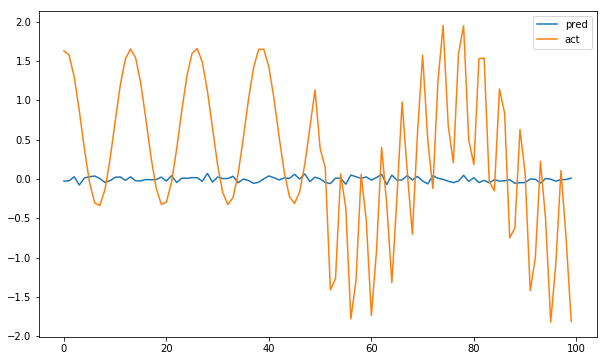

Epoch  1 MSE:  369.93211532070774


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


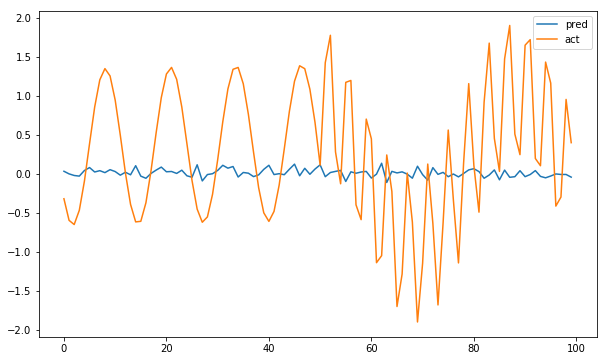

Epoch  2 MSE:  367.89333081577337


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


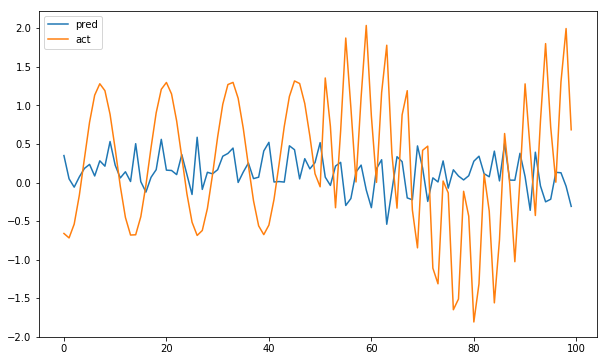

Epoch  3 MSE:  358.8658647077992


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


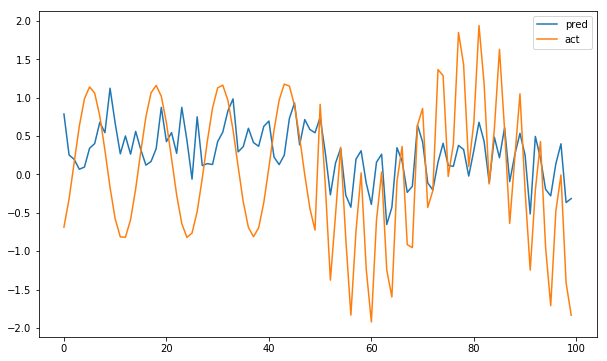

Epoch  4 MSE:  347.83874966847344


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


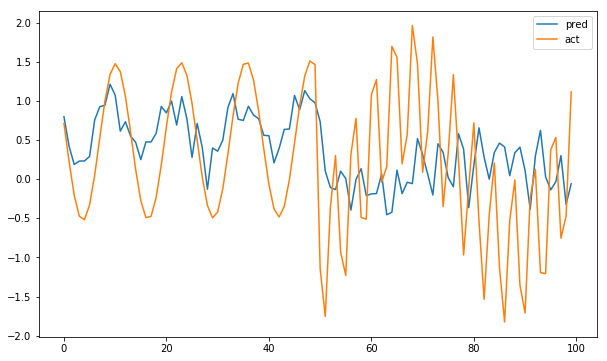

Epoch  5 MSE:  336.74968928467723


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


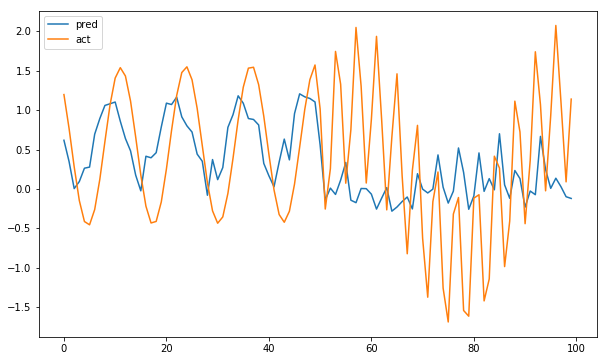

Epoch  6 MSE:  324.8360158504913


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


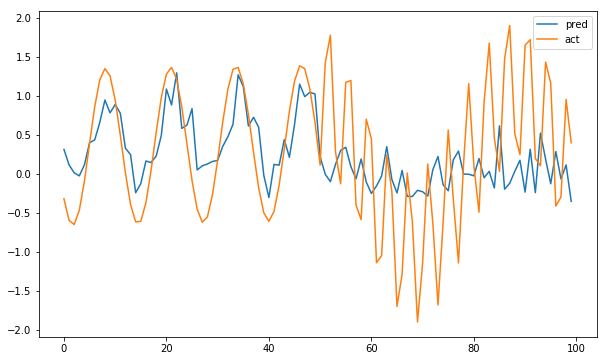

Epoch  7 MSE:  313.0434471130314


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


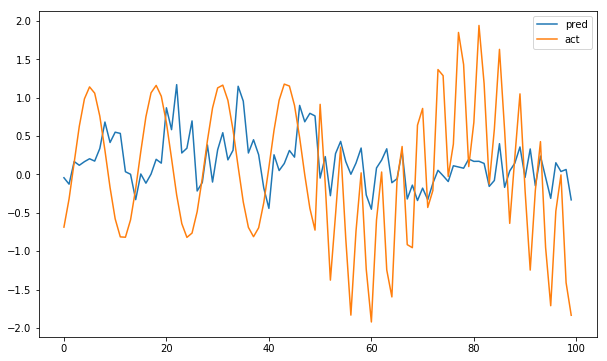

Epoch  8 MSE:  301.9831713365924


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


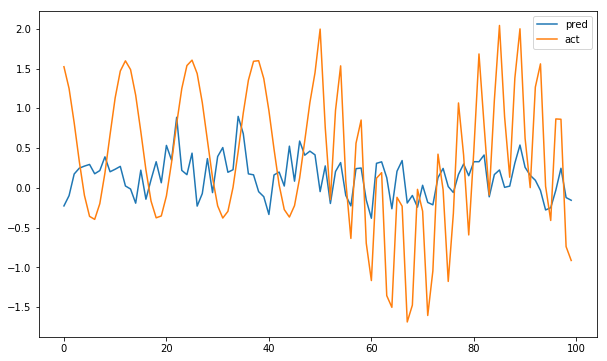

Epoch  9 MSE:  291.6289336987593


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


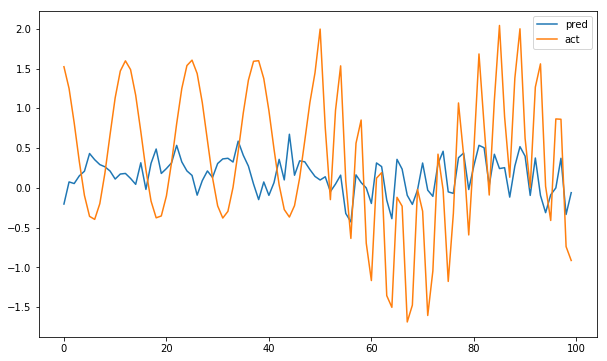

Epoch  10 MSE:  281.72316300876327


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


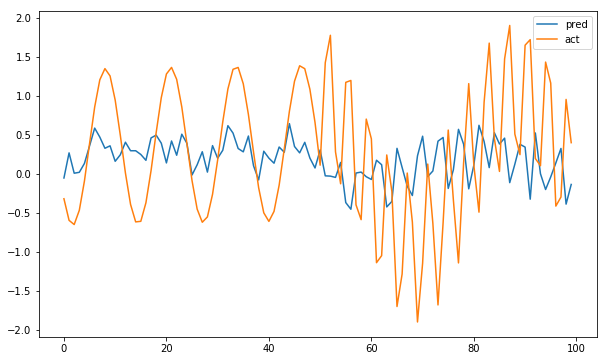

Epoch  11 MSE:  272.0833956422625


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


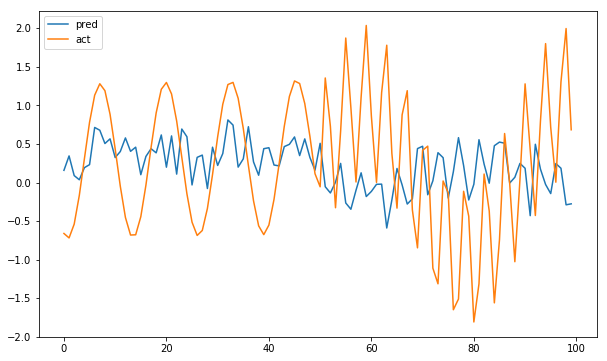

Epoch  12 MSE:  262.66106826526243


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


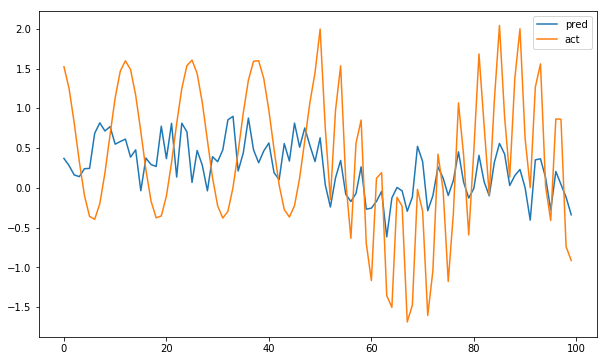

Epoch  13 MSE:  253.45167174933064


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


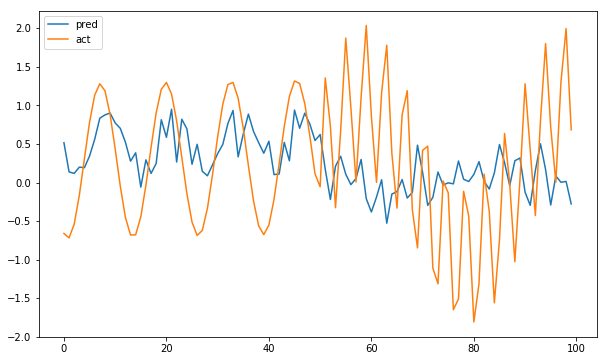

Epoch  14 MSE:  244.42279417036008


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


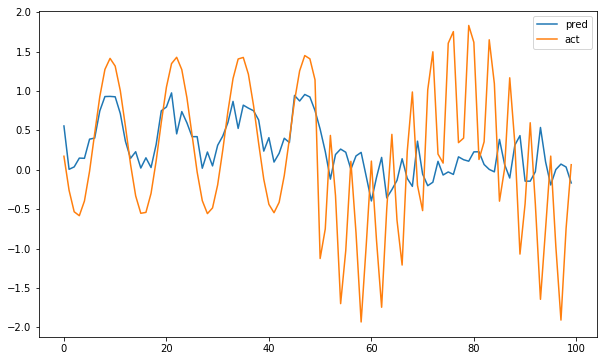

Epoch  15 MSE:  235.57002983571527


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


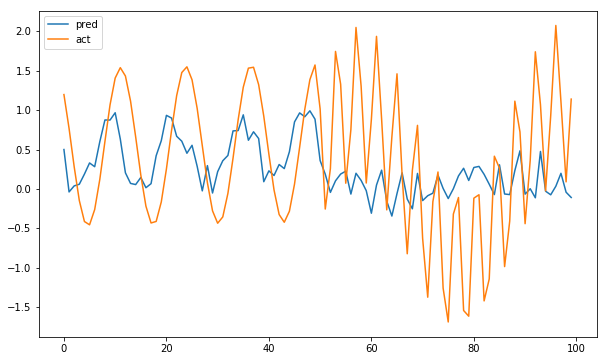

Epoch  16 MSE:  226.91284218577005


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


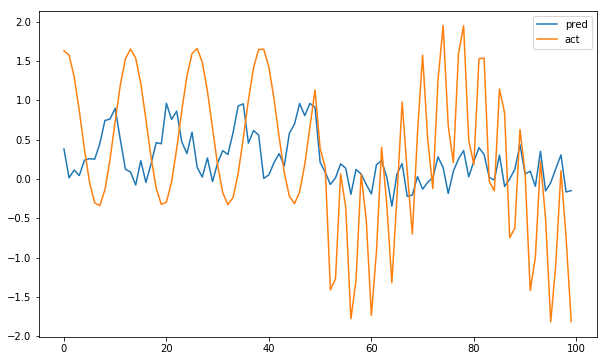

Epoch  17 MSE:  218.47972765862448


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


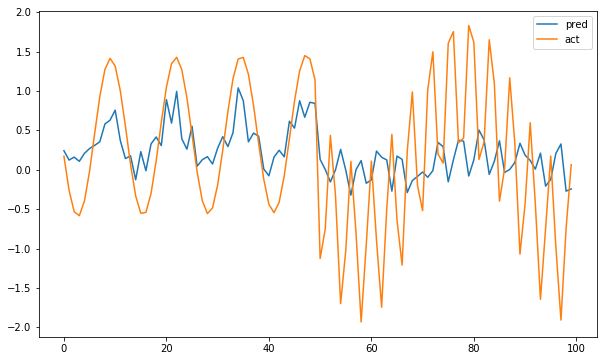

Epoch  18 MSE:  210.28731932485934


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


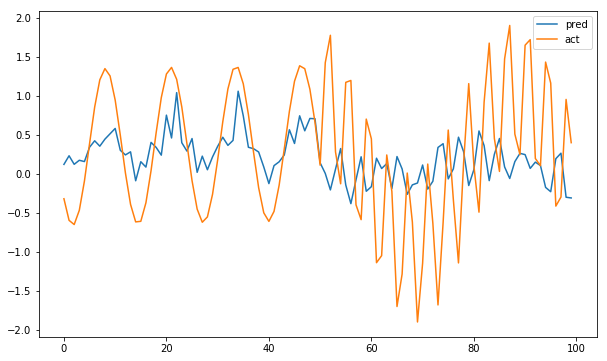

Epoch  19 MSE:  202.34655776954423


C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\MALAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


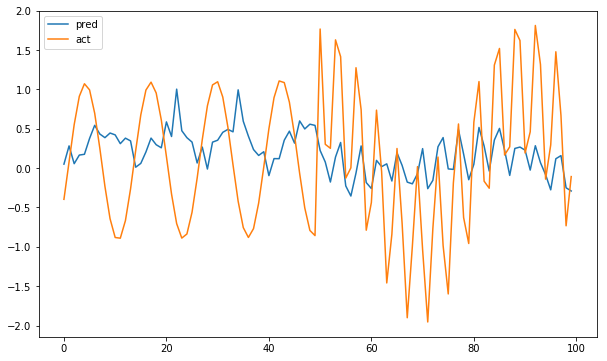

Epoch  20 MSE:  194.66637425977365
Training Completed


In [176]:
dataloader = DataLoader(cur_loader, batch_size=10, shuffle=True)
m1t.update_model(dataloader)

In [184]:
#Models
data_models = [Model_Trainer(LSTM(lstm_input_dim, lstm_hidden_dim, lstm_batch_size, lstm_output_dim, lstm_num_layers, lstm_num_epochs), lstm_num_epochs) for i in range(len(onehot_signal_combinations)+1)]
expert_models = expert.get_equations()

In [ ]:
class Zero_RCA:
    def __init__(self, snames, fnames, data_models_with_trainer, expert_models):
        self.data_models_with_trainer = data_models_with_trainer
        self.expert_models = expert_models
        self.snames = snames
        self.fnames = fnames
        
    def expert_predictions(self, time_frame):
        #"S1","S2","S3"... {Error1, }
        expert_predictions = {}
        for sn in self.snames:
            expert_predictions.update({sn:})
        for sensor in self.expert_models.keys():
            err_list = []
            for single_err in error:
                err_list.append(self.prior_distributions[single_err](time_frame))
            err_list, err_name = self.error_generation(err_list, list(error))
            err_list.insert(0, normal_func(sensor)(time_frame))
            err_name.insert(0, ())
            self.errors_list[sensor] = err_list
            self.errors_name_list[sensor] = err_name
        
    def bayesian_update(self, cur_signal):
        self.timeline = np.linspace(start, stop, samples)
        self.expert_predictions(time_frame)
        err_names = []
        probs = []
        errors = []
        error_names = []
        self.search_helper({}, {}, errors, error_names)
        # need to make sure all the lists do not have conflicts
        errors, error_names = self.check_conflicts(errors, error_names)
        for i in range(len(errors)):
            err_name = tuple(set([item for sublist in error_names[i].values() for item in sublist]))
            err_val = errors[i]
            for key, value in self.thetas.items():
                if err_name in value.keys():
                    data_size = self.stored_data[err_name][1][key].shape[0]
                    theta_prime = self.thetas[key][err_name]
                    val = self.error_calculation(error_names[i][key], theta_prime, time_frame)
                    err_val[key] = (1 - 1 / np.log(data_size)) * val + (1 / np.log(data_size)) * err_val[key]

            prob = 0.0
            for j in self.sensor_list:
                for i in range(len(sensor_inputs[j])):
                    gaussian_err = norm.pdf(sensor_inputs[j][i], loc=err_val[j][i], scale=self.sigmas[j])
                    prob += np.log(gaussian_err)

            err_names.append(err_name)
            probs.append(prob)

        error, pro = self.find_most_probable_error(err_names, probs)
        return error, pro, (err_names, probs)

In [487]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def normal_func(sensor):
    def normal_S1(x):
        return np.sin(x)
    def normal_S2(x):
        return np.cos(x)

    def normal_S3(x):
        return np.cos(1.1*x)

    if sensor == "S1":
        return normal_S1

    if sensor == "S2":
        return normal_S2

    if sensor == "S3":
        return normal_S3


def error_func(err,theta):
    def error1(x):
        return theta* np.sin(x)
    def error2(x):
        return theta* np.cos(x)
    def error3(x):
        return theta* np.sin(10*x)
    def error4(x):
        return theta* np.cos(5*x)

    if err == "Error1":
        return error1
    if err == "Error2":
        return error2
    if err == "Error3":
        return error3
    if err == "Error4":
        return error4


def composite_err_func(err_list, theta_list, time_frame):
    err_val = []
    for err,theta in zip(err_list,theta_list):
         err_val.append(error_func(err,theta)(time_frame))
    return np.sum(err_val, axis=0)



class BN():
    def __init__(self, sensor_list, errors, prior_distributions, sigmas):
        # sensor_list: how many sensors
        # errors: the errors associated with the sensors,
        # SHOULD BE {"S1": tuple[ERROR1, ERROR2, ..], "S2": tuple[ERROR1,ERROR2..]}
        # prior_distribution: expert's guess on the distributions SHOULD BE {"Error1": -1COS(5T),...}
        # sigmas: variances of gaussian
        # sensor_error_list: experts' guesses with the sensors
        # thetas: updated parameters
        # stored_data: the data stored with the particular error
        self.sensor_list = sensor_list
        self.errors = errors
        self.sensor_size = len(self.sensor_list)
        self.sigmas = sigmas
        self.sensor_error_list = []
        self.thetas = {}
        for sensor in sensor_list:
            self.thetas[sensor] = {}
        self.stored_data = {}
        self.errors_list = {}
        self.errors_name_list = {}
        self.prior_distributions = prior_distributions


    def error_generation(self,error_list, error_name_list):
        error_combination_list = list((powerset(error_list)))[1:]
        error_name_combination_list = list((powerset(error_name_list)))[1:]

        # Get all linear combinations of the experts' guess
        error_result_list = []
        for err in error_combination_list:
            err_arr = np.array(err)
            if err_arr.shape[0] > 1:
                err_arr = np.sum(err_arr, axis=0)
            if err_arr.shape[0] == 1:
                err_arr = err_arr.reshape((err_arr.shape[1],))
            error_result_list.append(err_arr)

        return error_result_list, error_name_combination_list


    def create_error_lists(self,time_frame):
        #"S1","S2","S3"... {Error1, }
        for sensor, error in self.errors.items():
            err_list = []
            for single_err in error:
                err_list.append(self.prior_distributions[single_err](time_frame))
            err_list, err_name = self.error_generation(err_list, list(error))
            err_list.insert(0, normal_func(sensor)(time_frame))
            err_name.insert(0, ())
            self.errors_list[sensor] = err_list
            self.errors_name_list[sensor] = err_name

    def error_calculation(self,error_list, theta, x):
        err_val = []
        for err in error_list:
            err_val.append(error_func(err,theta)(x))
        return np.sum(err_val, axis=0)


    def get_max(self,my_list):
        import operator
        index, value = max(enumerate(my_list), key=operator.itemgetter(1))
        return index,value


    def find_most_probable_error(self,err_names, probs):
        ind, prob = self.get_max(probs)
        print(ind, prob)
        print(err_names[ind])
        return err_names[ind], prob


    def search_helper(self, err_prefix, err_name_prefix, errors, error_names):
        if sorted(err_prefix.keys()) == sorted(self.errors_list.keys()):
            errors.append(deepcopy(err_prefix))
            error_names.append(deepcopy(err_name_prefix))
            return
        else:
            visited_sensors = list(err_prefix.keys())
            total_sensors = list(self.errors_list.keys())
            remained_sensors = np.setdiff1d(total_sensors, visited_sensors)
            targeted_sensors = remained_sensors[0]

            for i in range(len(self.errors_list[targeted_sensors])):
                err_prefix[targeted_sensors] = self.errors_list[targeted_sensors][i]
                err_name_prefix[targeted_sensors] = self.errors_name_list[targeted_sensors][i]

                self.search_helper(err_prefix,err_name_prefix,errors,error_names)
                err_prefix.pop(targeted_sensors, self.errors_list[targeted_sensors][i])
                err_name_prefix.pop(targeted_sensors,self.errors_name_list[targeted_sensors][i])



    def check_conflicts(self, errors, error_names):
        ret_err = []
        ret_err_name = []
        inv_err = collections.defaultdict(set)
        for k, v in self.errors.items():
            for item in v:
                inv_err[item].add(k)

        for i in range(len(error_names)):
            candidate = error_names[i]
            checked_error = set()
            wrong_config = False
            for sensor,error in candidate.items():
                for err in error:
                    if err in checked_error:
                        break
                    checked_error.add(err)
                    required_indices = list(inv_err[err])
                    wrong_config = any([ err not in candidate[i] for i in required_indices])
                    if wrong_config:
                        break
                if wrong_config:
                    break
            if not wrong_config:
                ret_err.append(errors[i])
                ret_err_name.append(error_names[i])
        return ret_err, ret_err_name



    # Baysian Calculation)
    # P(S2=y2|E3= 0,E4= 0)·P(S1=y1|E1= 1,E2= 0,E3= 0)· 1/ 16
    # Assuming each error occurs equally (so P(E1= 1)P(E2= 0)P(E3= 0)P(E4= 0) can be ignored )
    def bayesian_calculation_update(self, sensor_inputs,time_frame):
        self.create_error_lists(time_frame)
        err_names = []
        probs = []
        errors = []
        error_names = []
        self.search_helper({}, {}, errors, error_names)
        # need to make sure all the lists do not have conflicts
        errors, error_names = self.check_conflicts(errors, error_names)
        for i in range(len(errors)):
            err_name = tuple(set([item for sublist in error_names[i].values() for item in sublist]))
            err_val = errors[i]
            for key, value in self.thetas.items():
                if err_name in value.keys():
                    data_size = self.stored_data[err_name][1][key].shape[0]
                    theta_prime = self.thetas[key][err_name]
                    val = self.error_calculation(error_names[i][key], theta_prime, time_frame)
                    err_val[key] = (1 - 1 / np.log(data_size)) * val + (1 / np.log(data_size)) * err_val[key]

            prob = 0.0
            for j in self.sensor_list:
                for i in range(len(sensor_inputs[j])):
                    gaussian_err = norm.pdf(sensor_inputs[j][i], loc=err_val[j][i], scale=self.sigmas[j])
                    prob += np.log(gaussian_err)

            err_names.append(err_name)
            probs.append(prob)

        error, pro = self.find_most_probable_error(err_names, probs)
        return error, pro, (err_names, probs)



    # Train a new MLE that better fits the data
    def update(self, time_frame, sensor_inputs,errors):
        self.update_data_map(time_frame,sensor_inputs,errors)
        #list of empty tuples
        error_list = {}
        for s in self.sensor_list:
            error_list[s] = (tuple())

        for err in errors:
            for key, value in self.errors.items():
                if err in value:
                    error_list[key] = error_list[key] + (err,)
        for sensor_key,err_value in error_list.items():
            theta_prime = 0.0
            if err_value != ():
                theta_prime = self.MLE_update(sensor_key,err_value)
            if theta_prime != 0.0:
                self.thetas[sensor_key][errors] = theta_prime


    # update data_map
    def update_data_map(self,time_frame,sensor_inputs,error):
        if error in self.stored_data:
            old_time_frame = self.stored_data[error][0]
            old_sensors = self.stored_data[error][1]

            updated_time_frame = np.hstack((old_time_frame, time_frame))
            updated_sensor_inputs = deepcopy(sensor_inputs)
            for key,_ in updated_sensor_inputs.items():
                updated_sensor_inputs[key] = np.hstack((old_sensors[key], sensor_inputs[key]))

            self.stored_data[error] = (updated_time_frame, updated_sensor_inputs)
        else:
            self.stored_data[error] = (time_frame, sensor_inputs)

    #MLE_update calculation
    def MLE_update(self,sensor_key, err_value):
        y = []
        re_x, re_list = self.stored_data[err_value]
        for err in err_value:
            y.append(error_func(err, 1)(re_x))
        y = np.sum(np.array(y), axis=0)
        theta_prime = np.mean(np.divide(re_list[sensor_key], y, out=np.zeros_like(re_list[sensor_key]), where=y != 0))
        return theta_prime


if __name__ == '__main__':
    
    bn = BN(sensor_list=["S1", "S2", "S3"],
            errors={"S1": ["Error1", "Error2", "Error3"], "S2": ["Error3", "Error4"], "S3": ["Error1", "Error4"]},
            prior_distributions={"Error1": error_func("Error1", theta=4), "Error2": error_func("Error2", theta=2),
                                 "Error3": error_func("Error3", theta=0.5), "Error4": error_func("Error4", theta=-1)},
            sigmas={"S1": 1, "S2": 1, "S3": 1})
    
    
    x = np.linspace(start=0, stop=50, num=50)
    sensor_inputs = {"S1": error_func("Error3", theta=0.4)(x), "S2": error_func("Error3", theta=0.3)(x),
                     "S3": normal_func("S3")(x)}
    
    err, _,_ = bn.bayesian_calculation_update(sensor_inputs, x)
    bn.update(x, sensor_inputs, err)

    sensor_inputs = {"S1": error_func("Error3", theta=0.4)(x), "S2": error_func("Error3", theta=0.3)(x),
                     "S3": normal_func("S3")(x)}
    err,_,_ = bn.bayesian_calculation_update(sensor_inputs, x)
    bn.update(x, sensor_inputs, err)

    x = np.linspace(start=0, stop=50, num=50)
    sensor_inputs = {"S1": error_func("Error1", theta=3.5)(x), "S2": normal_func("S2")(x),
                     "S3": error_func("Error1", theta=3.2)(x)}
    err,_,_ = bn.bayesian_calculation_update(sensor_inputs, x)
    bn.update(x, sensor_inputs, err)

    x = np.linspace(start=0, stop=50, num=50)
    sensor_inputs = {"S1": composite_err_func(["Error1", "Error3"], theta_list=[3.5, 0.4], time_frame=x),
                     "S2": error_func("Error3", theta=0.4)(x), "S3": error_func("Error1", theta=3.5)(x)}
    err,_,_ = bn.bayesian_calculation_update(sensor_inputs, x)
    bn.update(x, sensor_inputs, err)







7 -138.45078373466472
('Error3',)
7 -137.87202959169804
('Error3',)
2 -148.79316526422645
('Error1',)
13 -144.23638426660307
('Error3', 'Error1')


\sin\left(\left(2.56725 \times t\right)\right)
\sin\left(\left(\left(1.50368\times10^{4}\right) \times t\right)\right)
\sin\left(\left(\left(9.58134\times10^{1}\right) \times t\right)\right)
\sin\left(\left(\left(7.80763\times10^{-4}\right) \times t\right)\right)
\sin\left(\left(\left(7.22249\times10^{4}\right) \times t\right)\right)
\left(\left(\sin\left(\left(2.89502 \times t\right)\right) + \sin\left(\left(\left(1.57082\times10^{-1}\right) \times t\right)\right)\right) + \sin\left(\left(\left(7.22815\times10^{-3}\right) \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(1.48234\times10^{-3}\right) \times t\right)\right) + \sin\left(\left(\left(1.20962\times10^{4}\right) \times t\right)\right)\right) + \sin\left(\left(8.63398 \times t\right)\right)\right)
\left(\left(\sin\left(\left(\left(3.53321\times10^{3}\right) \times t\right)\right) + \sin\left(\left(7.7257 \times t\right)\right)\right) + \sin\left(\left(\left(1.2481\times10^{-1}\right) \times t\right)\right)\right)